In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [3]:
path_prefix = './cs5228-2310-final-project/'
df_train = pd.read_csv(path_prefix + 'train.csv')
df_test = pd.read_csv(path_prefix + 'test.csv')

In [4]:
df_train.head()

,rent_approval_date,town,block,street_name,flat_type,flat_model,floor_area_sqm,furnished,lease_commence_date,latitude,longitude,elevation,subzone,planning_area,region,monthly_rent
0,2021-09,jurong east,257,Jurong East Street 24,3 room,new generation,67.0,yes,1983,1.344518,103.738630,0.0,yuhua east,jurong east,west region,1600
1,2022-05,bedok,119,bedok north road,4-room,new generation,92.0,yes,1978,1.330186,103.938717,0.0,bedok north,bedok,east region,2250
2,2022-10,toa payoh,157,lorong 1 toa payoh,3-room,improved,67.0,yes,1971,1.332242,103.845643,0.0,toa payoh central,toa payoh,central region,1900
3,2021-08,pasir ris,250,Pasir Ris Street 21,executive,apartment,149.0,yes,1993,1.370239,103.962894,0.0,pasir ris drive,pasir ris,east region,2850
4,2022-11,kallang/whampoa,34,Whampoa West,3-room,improved,68.0,yes,1972,1.320502,103.863341,0.0,bendemeer,kallang,central region,2100


## Data Preprocessing

In [53]:
def category_map(df_origin, df_train_):
    df = df_origin.copy()
    df_train_ = df_train_.copy()
    colums = ['town', 'flat_type', 'flat_type2', 'cluster', 
       'flat_model', 'subzone', 'planning_area','region'
         ]
    
    for col in colums:
        group_mean = df_train_.groupby(col)['monthly_rent'].mean()
        group_std = df_train_.groupby(col)['monthly_rent'].std()
        group_median = df_train_.groupby(col)['monthly_rent'].median()
        cat_map = group_mean.index
        mean_dict = {cat_map[i]:group_mean[cat_map[i]] for i in range(len(cat_map))}
        std_dict = {cat_map[i]:group_std[cat_map[i]] for i in range(len(cat_map))}
        median_dict = {cat_map[i]:group_median[cat_map[i]] for i in range(len(cat_map))}
        df[col+'_mean'] = df[col].apply(lambda x: mean_dict[x] if x in cat_map else df_train_['monthly_rent'].mean())
        df[col+'_std'] = df[col].apply(lambda x: std_dict[x] if x in cat_map else 0)
        #df[col+'_median'] = df[col].apply(lambda x: median_dict[x] if x in cat_map else -1)

        df.drop(columns=[col], inplace=True)
        

    return df


In [62]:
def data_preprocess(df, df_train_):
    df = df.copy()
    df_train_ = df_train_.copy()

    df['flat_type2'] = df['flat_type'].str.replace('-', ' ')
    df_train_['flat_type2'] = df_train_['flat_type'].str.replace('-', ' ')
    
    #normalize by date
    #df['monthly_rent'] = np.log(df['monthly_rent'])
    #df_train_['monthly_rent'] = np.log(df_train_['monthly_rent'])
    #means = df_train_.groupby('rent_approval_date')['monthly_rent'].mean()
    #stds = df_train_.groupby('rent_approval_date')['monthly_rent'].std()

    #df['monthly_rent'] = df.apply(lambda x: (x['monthly_rent'] - means[x['rent_approval_date']]) / stds[x['rent_approval_date']], axis=1)
    #df_train_['monthly_rent'] = df_train_.apply(lambda x: (x['monthly_rent'] - means[x['rent_approval_date']]) / stds[x['rent_approval_date']], axis=1)
    #normalize monthly rent by date

    #df['rent_approval_date_mean'] = df['rent_approval_date'].apply(lambda x: means[x])
    #df['rent_approval_date_std'] = df['rent_approval_date'].apply(lambda x: stds[x])
    
    #add coe price
    df_coe = pd.read_csv(path_prefix + 'auxiliary-data/auxiliary-data/sg-coe-prices.csv')
    month_to_numeric = {
        'january': 1,
        'february': 2,
        'march': 3,
        'april': 4,
        'may': 5,
        'june': 6,
        'july': 7,
        'august': 8,
        'september': 9,
        'october': 10,
        'november': 11,
        'december': 12
    }

    df_coe['month'] = df_coe['month'].apply(lambda x: month_to_numeric[x.lower()])
    df_coe['month'] = df_coe['month'].apply(lambda x: f'{x:02d}')

    df_coe['date'] = df_coe['year'].astype(str) + '-' + df_coe['month']
    df_coe = df_coe[['date', 'price']]
    avg_price_bids_quota = df_coe.groupby('date').mean().reset_index()
    avg_price_bids_quota['date'] = pd.to_datetime(avg_price_bids_quota['date'])

    #df['coe_price'] = df['rent_approval_date'].apply(lambda x: avg_price_bids_quota[avg_price_bids_quota['date'] == x]['price'].values[0])

    

    df = category_map(df, df_train_)
    df.drop(['elevation'], axis=1, inplace=True)
    df.drop(['furnished'], axis=1, inplace=True)

    for col in df.columns:
        #change -1 to KNN K=8
        if df[col].dtype == 'float64':
            df[col].fillna(0, inplace=True)
    
    
    #df.drop(['latitude'], axis=1, inplace=True)
    #df.drop(['longitude'], axis=1, inplace=True)
    #df['rent_approval_date'] = pd.to_datetime(df['rent_approval_date']).astype('int64')
    #df.drop(['rent_approval_date'], axis=1, inplace=True)
    df.drop(['block'], axis=1, inplace=True)
    df.drop(['street_name'], axis=1, inplace=True)

    return df

## try with attributes > 0.3
* block
* street_name
* flat_type
* floor_area_sqm
* subzone
* rent_approval_date_mean
* price
## with method
* xgboost
* lgbm

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import xgboost as xgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

In [56]:
df_train = pd.read_csv(path_prefix + 'train.csv')
df_test = pd.read_csv(path_prefix + 'test.csv')

In [57]:
df_train

,rent_approval_date,town,block,street_name,flat_type,flat_model,floor_area_sqm,furnished,lease_commence_date,latitude,longitude,elevation,subzone,planning_area,region,monthly_rent
0,2021-09,jurong east,257,Jurong East Street 24,3 room,new generation,67.0,yes,1983,1.344518,103.738630,0.0,yuhua east,jurong east,west region,1600
1,2022-05,bedok,119,bedok north road,4-room,new generation,92.0,yes,1978,1.330186,103.938717,0.0,bedok north,bedok,east region,2250
2,2022-10,toa payoh,157,lorong 1 toa payoh,3-room,improved,67.0,yes,1971,1.332242,103.845643,0.0,toa payoh central,toa payoh,central region,1900
3,2021-08,pasir ris,250,Pasir Ris Street 21,executive,apartment,149.0,yes,1993,1.370239,103.962894,0.0,pasir ris drive,pasir ris,east region,2850
4,2022-11,kallang/whampoa,34,Whampoa West,3-room,improved,68.0,yes,1972,1.320502,103.863341,0.0,bendemeer,kallang,central region,2100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,2021-09,ang mo kio,441,Ang Mo Kio Avenue 10,3 room,new generation,67.0,yes,1979,1.366050,103.854168,0.0,chong boon,ang mo kio,north-east region,2200
59996,2023-04,bukit merah,95a,henderson road,4-room,model a,83.0,yes,2019,1.286493,103.821434,0.0,henderson hill,bukit merah,central region,4100
59997,2022-06,tampines,862a,tampines street 83,5-room,improved,122.0,yes,1988,1.355064,103.936507,0.0,tampines west,tampines,east region,2250
59998,2023-01,bedok,67,Bedok Sth Avenue 3,5-room,standard,123.0,yes,1977,1.318974,103.944076,0.0,bedok south,bedok,east region,4700


In [58]:
from scipy.stats import zscore
def handle_outliers(group, attribute):
    z_scores = zscore(group[attribute])
    threshold = 3 
    outlier_indices = np.where(np.abs(z_scores) > threshold)[0]
    print(len(outlier_indices))
    return group[(z_scores < threshold)] 

In [59]:
# handle outlier
grouped = df_train.groupby('rent_approval_date', group_keys=False)
df_train = grouped.apply(handle_outliers, attribute='monthly_rent')
df_train.reset_index(drop=True, inplace=True)

16
6
16
12
15
6
13
9
6
6
8
13
3
2
5
9
11
6
17
1
15
10
5
5
7
7
5
9
5
7
7


<Axes: xlabel='latitude', ylabel='longitude'>

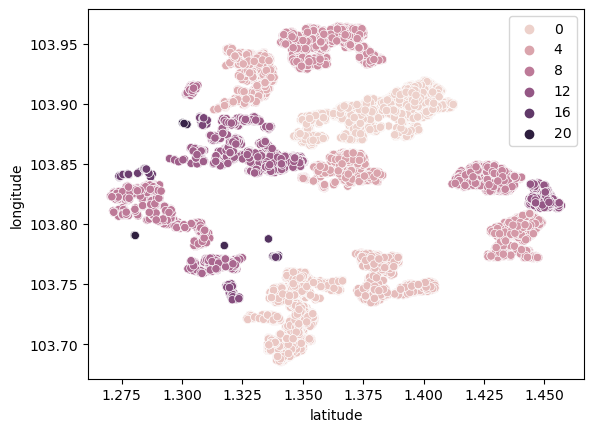

In [60]:
#add cluster feature
df_lat_long = df_train[['latitude', 'longitude']]
df_lat_long_test = df_test[['latitude', 'longitude']]
df_total = pd.concat([df_lat_long, df_lat_long_test], axis=0)
from sklearn.cluster import DBSCAN
DBSCAN_model = DBSCAN(eps=0.005, min_samples=1)
DBSCAN_model.fit(df_total)
#plot
sns.scatterplot(x='latitude', y='longitude', hue=DBSCAN_model.labels_, data=df_total)

In [45]:
df_train['cluster'] = DBSCAN_model.labels_[:len(df_train)]
df_test['cluster'] = DBSCAN_model.labels_[len(df_train):]

In [46]:
import lightgbm as lgb
import xgboost as xgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [47]:
# =============== model based on year ================== #

In [48]:
#split by year
dates = pd.to_datetime(df_train['rent_approval_date']).unique()
dates = sorted(dates)
dates

[Timestamp('2021-01-01 00:00:00'),
 Timestamp('2021-02-01 00:00:00'),
 Timestamp('2021-03-01 00:00:00'),
 Timestamp('2021-04-01 00:00:00'),
 Timestamp('2021-05-01 00:00:00'),
 Timestamp('2021-06-01 00:00:00'),
 Timestamp('2021-07-01 00:00:00'),
 Timestamp('2021-08-01 00:00:00'),
 Timestamp('2021-09-01 00:00:00'),
 Timestamp('2021-10-01 00:00:00'),
 Timestamp('2021-11-01 00:00:00'),
 Timestamp('2021-12-01 00:00:00'),
 Timestamp('2022-01-01 00:00:00'),
 Timestamp('2022-02-01 00:00:00'),
 Timestamp('2022-03-01 00:00:00'),
 Timestamp('2022-04-01 00:00:00'),
 Timestamp('2022-05-01 00:00:00'),
 Timestamp('2022-06-01 00:00:00'),
 Timestamp('2022-07-01 00:00:00'),
 Timestamp('2022-08-01 00:00:00'),
 Timestamp('2022-09-01 00:00:00'),
 Timestamp('2022-10-01 00:00:00'),
 Timestamp('2022-11-01 00:00:00'),
 Timestamp('2022-12-01 00:00:00'),
 Timestamp('2023-01-01 00:00:00'),
 Timestamp('2023-02-01 00:00:00'),
 Timestamp('2023-03-01 00:00:00'),
 Timestamp('2023-04-01 00:00:00'),
 Timestamp('2023-05-

In [49]:
#split by dates
df_train_dates = {}
df_test_dates = {}
df_train['rent_approval_date'] = pd.to_datetime(df_train['rent_approval_date'])
df_test['rent_approval_date'] = pd.to_datetime(df_test['rent_approval_date'])
for date in dates:
    df_train_dates[date] = df_train[df_train['rent_approval_date'] == date]
    df_test_dates[date] = df_test[df_test['rent_approval_date'] == date]

df_test_dates[dates[0]]

,rent_approval_date,town,block,street_name,flat_type,flat_model,floor_area_sqm,furnished,lease_commence_date,latitude,longitude,elevation,subzone,planning_area,region,cluster
34,2021-01-01,jurong west,515,jurong west street 52,3 room,model a,74.0,yes,1984,1.346424,103.720898,0.0,hong kah,jurong west,west region,1
36,2021-01-01,ang mo kio,323,ang mo kio avenue 3,2 room,improved,49.0,yes,1977,1.367890,103.847599,0.0,townsville,ang mo kio,north-east region,4
50,2021-01-01,ang mo kio,452,Ang Mo Kio Avenue 10,3 room,new generation,68.0,yes,1979,1.368898,103.856201,0.0,chong boon,ang mo kio,north-east region,4
53,2021-01-01,woodlands,24,Marsiling Drive,3 room,new generation,67.0,yes,1977,1.441505,103.772132,0.0,north coast,woodlands,north region,5
58,2021-01-01,pasir ris,569,pasir ris street 51,4 room,model a,104.0,yes,1992,1.369653,103.949169,0.0,pasir ris central,pasir ris,east region,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29856,2021-01-01,bishan,441,sin ming avenue,5 room,improved,122.0,yes,1990,1.359084,103.831751,0.0,upper thomson,bishan,central region,4
29878,2021-01-01,sembawang,412,sembawang drive,5 room,improved,110.0,yes,2001,1.451891,103.818161,0.0,sembawang north,sembawang,north region,12
29923,2021-01-01,woodlands,216,Marsiling Lane,5 room,improved,118.0,yes,1981,1.447134,103.772172,0.0,north coast,woodlands,north region,5
29942,2021-01-01,bedok,219a,Bedok Central,3 room,model a,69.0,yes,2010,1.325311,103.933278,0.0,bedok north,bedok,east region,3


In [63]:
df_train_dates_processed = {}

for date in dates:
    df_train_dates_processed[date] = data_preprocess(df_train_dates[date], df_train_dates[date])

df_train_dates_processed[dates[10]]

,rent_approval_date,floor_area_sqm,lease_commence_date,latitude,longitude,monthly_rent,town_mean,town_std,flat_type_mean,flat_type_std,...,cluster_mean,cluster_std,flat_model_mean,flat_model_std,subzone_mean,subzone_std,planning_area_mean,planning_area_std,region_mean,region_std
20886,2021-11-01,67.0,1978,1.311660,103.761761,1600,2230.303030,392.906212,2054.042904,304.627112,...,2230.303030,392.906212,2161.473088,354.980929,2277.272727,506.144069,2230.303030,392.906212,2224.623656,409.492851
20887,2021-11-01,90.0,2003,1.321499,103.738982,1900,2271.538462,464.940288,2359.319527,388.465713,...,2225.000000,463.680925,2264.149140,410.215102,2225.000000,463.680925,2271.538462,464.940288,2224.623656,409.492851
20888,2021-11-01,126.0,1993,1.354098,103.958267,2100,2306.737589,368.598691,2453.382664,384.014774,...,2334.975369,362.347099,2327.289048,405.559846,2303.750000,383.420234,2306.737589,368.598691,2304.952077,364.202784
20889,2021-11-01,98.0,1977,1.368359,103.847746,2700,2221.428571,399.871408,2359.319527,388.465713,...,2296.794872,436.469690,2161.473088,354.980929,2310.869565,373.544607,2221.428571,399.871408,2254.545455,374.130991
20890,2021-11-01,103.0,1984,1.337144,103.928434,2100,2249.545455,362.742829,2359.319527,388.465713,...,2263.524590,357.680596,2264.149140,410.215102,2368.750000,301.592993,2249.545455,362.742829,2304.952077,364.202784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22783,2021-11-01,68.0,1981,1.376357,103.842056,1900,2221.428571,399.871408,2054.042904,304.627112,...,2296.794872,436.469690,2161.473088,354.980929,2267.241379,388.512700,2221.428571,399.871408,2254.545455,374.130991
22784,2021-11-01,126.0,1993,1.364398,103.960572,2500,2399.193548,341.943809,2453.382664,384.014774,...,2334.975369,362.347099,2327.289048,405.559846,2398.275862,354.431829,2399.193548,341.943809,2304.952077,364.202784
22785,2021-11-01,152.0,1985,1.359086,103.949767,2950,2306.737589,368.598691,2485.200000,411.430628,...,2334.975369,362.347099,2526.712329,444.728553,2303.750000,383.420234,2306.737589,368.598691,2304.952077,364.202784
22786,2021-11-01,113.0,2015,1.343608,103.713869,2400,2267.763158,428.164413,2453.382664,384.014774,...,2244.401544,432.942798,2327.289048,405.559846,1990.909091,287.939388,2267.763158,428.164413,2224.623656,409.492851


In [64]:
df_test_processed = {}

for date in dates:
    df_test_processed[date] = data_preprocess(df_test_dates[date], df_train_dates[date])

df_test_processed[dates[0]]

,rent_approval_date,floor_area_sqm,lease_commence_date,latitude,longitude,town_mean,town_std,flat_type_mean,flat_type_std,flat_type2_mean,...,cluster_mean,cluster_std,flat_model_mean,flat_model_std,subzone_mean,subzone_std,planning_area_mean,planning_area_std,region_mean,region_std
34,2021-01-01,74.0,1984,1.346424,103.720898,2225.531915,352.724955,1899.550225,254.508491,1899.550225,...,2137.678571,369.272224,2144.928826,368.073094,2126.666667,317.786887,2225.531915,352.724955,2120.275591,356.971044
36,2021-01-01,49.0,1977,1.367890,103.847599,2014.400000,316.598351,1522.916667,248.026632,1522.916667,...,2070.890411,340.322203,2200.919732,367.929137,2042.307692,342.080737,2014.400000,316.598351,2093.110236,307.214006
50,2021-01-01,68.0,1979,1.368898,103.856201,2014.400000,316.598351,1899.550225,254.508491,1899.550225,...,2070.890411,340.322203,1991.645885,298.766270,1989.130435,348.032301,2014.400000,316.598351,2093.110236,307.214006
53,2021-01-01,67.0,1977,1.441505,103.772132,2033.486239,327.522620,1899.550225,254.508491,1899.550225,...,2033.486239,327.522620,1991.645885,298.766270,1883.333333,160.727513,2033.486239,327.522620,2029.889299,306.581490
58,2021-01-01,104.0,1992,1.369653,103.949169,2259.677419,232.209401,2225.105189,342.845449,2225.105189,...,2194.131455,297.831505,2144.928826,368.073094,2353.571429,244.528027,2259.677419,232.209401,2159.545455,329.213080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29856,2021-01-01,122.0,1990,1.359084,103.831751,2483.333333,301.821953,2300.186567,335.987821,2300.186567,...,2070.890411,340.322203,2200.919732,367.929137,2192.857143,258.889570,2483.333333,301.821953,2280.674157,450.122100
29878,2021-01-01,110.0,2001,1.451891,103.818161,2104.310345,241.029314,2300.186567,335.987821,2300.186567,...,2104.310345,241.029314,2200.919732,367.929137,2090.909091,180.367590,2104.310345,241.029314,2029.889299,306.581490
29923,2021-01-01,118.0,1981,1.447134,103.772172,2033.486239,327.522620,2300.186567,335.987821,2300.186567,...,2033.486239,327.522620,2200.919732,367.929137,1883.333333,160.727513,2033.486239,327.522620,2029.889299,306.581490
29942,2021-01-01,69.0,2010,1.325311,103.933278,2096.581197,372.938384,1899.550225,254.508491,1899.550225,...,2100.000000,369.947718,2144.928826,368.073094,1966.000000,341.282096,2096.581197,372.938384,2159.545455,329.213080


In [65]:
from flaml import AutoML

automl_settings = {
    "time_budget": 10,  # in seconds
    "metric": 'rmse',
    "task": 'regression',
    "eval_method": 'cv',
}

In [66]:
len(dates)

31

In [67]:
models = {}
scores = {}

In [68]:
for date in dates[17:]:
    X = df_train_dates_processed[date].drop(['monthly_rent'], axis=1)
    y = df_train_dates_processed[date]['monthly_rent']
    print("date: ", date, "start training")

    automl = AutoML()
    automl.fit(X_train=X, y_train=y, **automl_settings)
    models[date] = automl
    y_pred = automl.predict(X)
    scores[date] = mean_squared_error(y, y_pred, squared=False)

    print("date: ", date, "end training")


date:  2021-01-01 00:00:00 start training
[flaml.automl.logger: 10-26 23:43:32] {1679} INFO - task = regression
[flaml.automl.logger: 10-26 23:43:32] {1690} INFO - Evaluation method: cv
[flaml.automl.logger: 10-26 23:43:32] {1788} INFO - Minimizing error metric: rmse
[flaml.automl.logger: 10-26 23:43:32] {1900} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree', 'xgb_limitdepth']
[flaml.automl.logger: 10-26 23:43:32] {2218} INFO - iteration 0, current learner lgbm


[flaml.automl.logger: 10-26 23:43:32] {2344} INFO - Estimated sufficient time budget=1807s. Estimated necessary time budget=15s.
[flaml.automl.logger: 10-26 23:43:32] {2391} INFO -  at 0.2s,	estimator lgbm's best error=320.9016,	best estimator lgbm's best error=320.9016
[flaml.automl.logger: 10-26 23:43:32] {2218} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 10-26 23:43:32] {2391} INFO -  at 0.4s,	estimator lgbm's best error=320.9016,	best estimator lgbm's best error=320.9016
[flaml.automl.logger: 10-26 23:43:32] {2218} INFO - iteration 2, current learner lgbm
[flaml.automl.logger: 10-26 23:43:32] {2391} INFO -  at 0.5s,	estimator lgbm's best error=284.5300,	best estimator lgbm's best error=284.5300
[flaml.automl.logger: 10-26 23:43:32] {2218} INFO - iteration 3, current learner xgboost
[flaml.automl.logger: 10-26 23:43:32] {2391} INFO -  at 0.7s,	estimator xgboost's best error=320.9166,	best estimator lgbm's best error=284.5300
[flaml.automl.logger: 10-26 23:43:32] {

In [ ]:
for date in dates:
    print(date, scores[date])

2021-01-01 00:00:00 153.19584667943997
2021-02-01 00:00:00 131.0362128400135
2021-03-01 00:00:00 148.72854226818697
2021-04-01 00:00:00 131.41484112652927
2021-05-01 00:00:00 153.93887364024803
2021-06-01 00:00:00 154.93894314245267
2021-07-01 00:00:00 176.05421916099783
2021-08-01 00:00:00 158.0214117218743
2021-09-01 00:00:00 157.03347289682466
2021-10-01 00:00:00 151.95918667405587
2021-11-01 00:00:00 149.16856640405936
2021-12-01 00:00:00 190.89367806795053
2022-01-01 00:00:00 210.0439644959206
2022-02-01 00:00:00 177.35068525040919
2022-03-01 00:00:00 251.34177424773364
2022-04-01 00:00:00 248.47517466852872
2022-05-01 00:00:00 255.52459412322906
2022-06-01 00:00:00 265.86493747752684
2022-07-01 00:00:00 286.50307971310997
2022-08-01 00:00:00 267.5001127326304
2022-09-01 00:00:00 306.5941954072699
2022-10-01 00:00:00 339.68942497025637
2022-11-01 00:00:00 283.9241936096864
2022-12-01 00:00:00 344.7882343133219
2023-01-01 00:00:00 296.26233633701196
2023-02-01 00:00:00 412.91563072

In [ ]:
#test
df_test_pred = {}
for date in dates:
    X_test = df_test_processed[date]
    y_pred = models[date].predict(X_test)
    df_test_pred[date] = pd.DataFrame({'index': X_test.index, 'monthly_rent': y_pred})

df_test_pred[dates[0]]

,index,monthly_rent
0,34,1893.381296
1,36,1550.807336
2,50,2019.356318
3,53,1747.555118
4,58,2255.146432
...,...,...
1047,29856,2433.852295
1048,29878,2094.799095
1049,29923,2420.489249
1050,29942,2146.793518


In [ ]:
#merge
df_test_pred_all = pd.concat([df_test_pred[date] for date in dates])
df_test_pred_all.sort_values(by=['index'], inplace=True)
df_test_pred_all.reset_index(drop=True, inplace=True)
df_test_pred_all

,index,monthly_rent
0,0,3075.442655
1,1,2553.885957
2,2,3269.889772
3,3,2202.513230
4,4,2177.355505
...,...,...
29995,29995,3343.650908
29996,29996,3163.628547
29997,29997,2447.663409
29998,29998,3230.621920


In [ ]:
#submission
df_submit = pd.read_csv(path_prefix + 'example-submission.csv')
df_submit['Predicted'] = df_test_pred_all['monthly_rent']
df_submit.to_csv('submission.csv', index=False)